In this notebook, we are going to model a transformer(Time Series Transformer). Unlike the LSTMs, they don't understand "Order" naturally and we must inject positional encodings so the model knows the sequence order.

In [ ]:
#The Setup(Data and positional encoding)

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os

# 1. Load & Scale Data (Same as LSTM)
PROCESSED_PATH = os.path.join("..", "data", "processed")
df = pd.read_csv(os.path.join(PROCESSED_PATH, "daily_sales_sentiment.csv"))
df['ds'] = pd.to_datetime(df['ds'])

# Features: Sales, Sentiment, Volume
data = df[['y', 'sentiment_avg', 'sales_volume']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 2. Sequence Creation Function
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0]) 
    return np.array(X), np.array(y)

SEQ_LENGTH = 30
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split
train_size = int(len(X) * 0.8)
X_train = torch.FloatTensor(X[:train_size])
y_train = torch.FloatTensor(y[:train_size]).view(-1, 1)
X_test = torch.FloatTensor(X[train_size:])
y_test = torch.FloatTensor(y[train_size:]).view(-1, 1)

# 3. Positional Encoding (The "Transformer" Secret Sauce)
# This class adds a mathematical pattern to the data so the model knows "Time"
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [3]:
#The Transformer Model:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim):
        super(TimeSeriesTransformer, self).__init__()
        self.model_type = 'Transformer'
        
        # 1. Input Embedding
        # Projects our 3 features (Sales, Sentiment, Volume) up to 'd_model' size (e.g. 64)
        self.input_linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # 2. Transformer Encoder Layer
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # 3. Decoder (Output)
        self.decoder = nn.Linear(d_model, output_dim)

    def forward(self, src):
        # src shape: [batch, seq_len, features]
        src = self.input_linear(src) * math.sqrt(src.size(-1))
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        
        # We take the output of the LAST time step to predict the future
        output = output[:, -1, :] 
        output = self.decoder(output)
        return output

# Hyperparameters
input_dim = 3       # Sales, Sentiment, Volume
d_model = 64        # Size of internal vector
nhead = 4           # Number of "Attention Heads" (Parallel processing)
num_layers = 2      # Number of Transformer blocks
output_dim = 1      # Predicting 1 value (Sales)

model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) # Lower LR for Transformers

print(model)

TimeSeriesTransformer(
  (input_linear): Linear(in_features=3, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=64, out_features=1, bias=True)
)


We now have to train the Loop and we will be watching the loss curve

Starting Transformer Training...
Epoch 0: Loss 0.270569
Epoch 20: Loss 0.063530
Epoch 40: Loss 0.012103
Epoch 60: Loss 0.006368
Epoch 80: Loss 0.004932
Epoch 100: Loss 0.004492
Epoch 120: Loss 0.004538
Epoch 140: Loss 0.003934


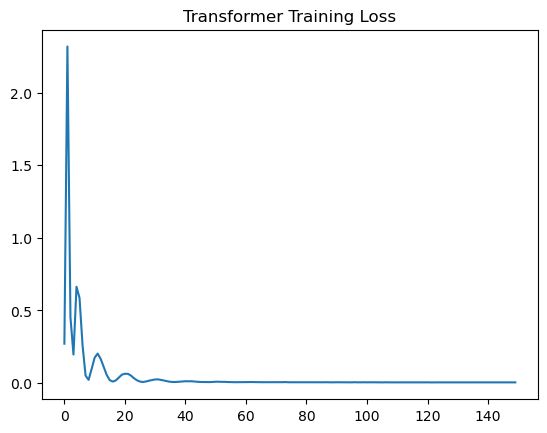

In [5]:
epochs = 150 # Transformers need a bit more time to learn
loss_history = []

print("Starting Transformer Training...")
model.train()
for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if i % 20 == 0:
        print(f"Epoch {i}: Loss {loss.item():.6f}")

plt.plot(loss_history)
plt.title("Transformer Training Loss")
plt.show()

From the above plot, it is evident that from epoch 25 to epoch 140 there is no learning at all. This means our Transformer cannot be ideal for this kind of dataset because it is smaller and it needs a lot of data points to learn sufficiently

We will now have a three way showdown of the prophet vs LSTM vs Transformer

Transformer MAE: $25588.95


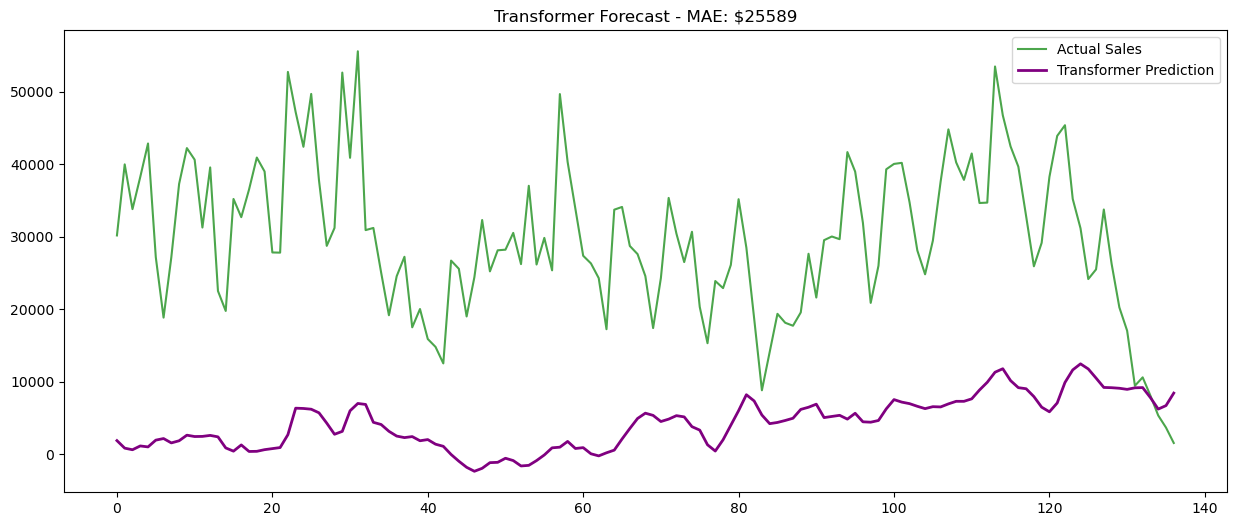

In [6]:
# 1. Predict
model.eval()
with torch.no_grad():
    test_predictions = model(X_test).numpy()

# 2. Inverse Scale
dummy_matrix = np.zeros((len(test_predictions), 3))
dummy_matrix[:, 0] = test_predictions.flatten()
inverse_predictions = scaler.inverse_transform(dummy_matrix)[:, 0]

dummy_actuals = np.zeros((len(y_test), 3))
dummy_actuals[:, 0] = y_test.numpy().flatten()
inverse_actuals = scaler.inverse_transform(dummy_actuals)[:, 0]

# 3. Calculate Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(inverse_actuals, inverse_predictions)

print(f"Transformer MAE: ${mae:.2f}")

# 4. Save Plot for Portfolio
plt.figure(figsize=(15, 6))
plt.plot(inverse_actuals, label='Actual Sales', color='green', alpha=0.7)
plt.plot(inverse_predictions, label='Transformer Prediction', color='purple', linewidth=2)
plt.title(f"Transformer Forecast - MAE: ${mae:.0f}")
plt.legend()
plt.savefig('../results_transformer.png')
plt.show()

We have to do a reality check and from what we can see, transformers did not perform well at all and we have just proved the fundamental rule of AI which says that complexity does not guarantee accuracy. They usually need a lot of datapoints to learn effectively and we did not have enough daa for that in our dataset.It failed to capture the magnitude of sales in the flat purple line. 